In [1]:
import matplotlib.pyplot as plt
import os 
import drjit as dr
import mitsuba as mi
import random
import numpy as np

mi.set_variant('cuda_ad_rgb')

In [2]:
sensor_count = 7
sensor = {
    'type': 'batch',
    'film': {
        'type': 'hdrfilm',
        'width': 512 * sensor_count, 'height': 512,
        'filter': {'type': 'gaussian'},
        'sample_border': True
    }
}

In [3]:
import numpy as np 
def generate_points_circle(r, amount, height):
    return [mi.ScalarPoint3f(np.sin(2*np.pi/amount*x)*r, -np.cos(2*np.pi/amount*x)*r, height) for x in range(0,amount + 1)]   

In [4]:
# Generate random viewpoints in upper hemispher
def random_upper_hemisphere(u, v, r):
    # theta = u * (dr.pi / 4) + (dr.pi/4)
    theta = u * (dr.pi / 3)
    phi = (v * dr.pi * 2) - dr.pi

    x = r * dr.sin(theta) * dr.cos(phi)
    y = r * dr.sin(theta) * dr.sin(phi)
    z = r * dr.cos(theta)
    return x, y, z

In [5]:
from mitsuba import ScalarTransform4f as T

def generate_sensors_circle(points, batch_sensor, sensor_count):
   
    for i in range(sensor_count):
        mi.UInt()
        batch_sensor[f"sensor_{i}"] = {
            'type': 'perspective',
            'fov': 45,
            'to_world': T.look_at(target=[0, 0, 0], origin=points[i], up=[0, 0, 1])
        }

In [6]:
from mitsuba import ScalarTransform4f as T

origins = []
for i in range(sensor_count):
    d = 4
    u = random.uniform(0, 1)
    v = random.uniform(0, 1)
    x_v, y_v, z_v = random_upper_hemisphere(u, v, d)

    origin = mi.ScalarPoint3f(x_v, y_v, z_v)
    origins.append(origin)

    sensor[f"sensor_{i}"] = {
        'type': 'perspective',
        'fov': 45,
        'to_world': T.look_at(target=[0, 0, 0], origin=origin, up=[0, 0, 1])
    }

In [7]:
scene_dict_ref = {
    'type': 'scene',
    'integrator': {
        'type': 'direct_reparam',
    },
    'sensor': sensor,
    'sphere_2': {
        'type': 'sphere',
        'center': [0, 0, 5],
        'radius': 1,
       'emitter': {
            'type': 'area',
            'radiance': {
                'type': 'rgb',
                'value': 15.0,
            }
        }
    },
    'heightfield': {
        'type': 'heightfield',
        'filename': 'data/oppenheimer_smooth.bmp',
        'max_height': 0.3,
        'bsdf': {
            'type': 'diffuse',
            'reflectance': {
                'type': 'rgb',
                'value': [0.5, 0.5, 0.5]
            }
        }
    }
}

scene_target = mi.load_dict(scene_dict_ref)

In [8]:
scene_dict_opt = {
    'type': 'scene',
    'integrator': {
        'type': 'direct_reparam',
    },
    'sensor': sensor,
    'sphere_2': {
        'type': 'sphere',
        'center': [0, 0, 5],
        'radius': 1,
       'emitter': {
            'type': 'area',
            'radiance': {
                'type': 'rgb',
                'value': 15.0,
            }
        }
    },
    'heightfield': {
        'type': 'heightfield',
        'resolution_x': 1920,
        'resolution_y': 1080,
        'max_height': 0.3,
        'bsdf': {
            'type': 'diffuse',
            'reflectance': {
                'type': 'rgb',
                'value': [0.5, 0.5, 0.5]
            }
        }
    }
}

In [9]:
def update(pi, params, key):
    params[key] *= (1 + pi)    
    params.update()

In [10]:
def render_fd_gradient_img(src_scene, params, iteration):
    Δ = 5e-4
    fd_integrator = mi.load_dict({"type": "direct"})
    fd_spp = 1024
    fd_repeat = 128
    img1 = dr.zeros(mi.TensorXf, (256, 256, 3))
    img2 = dr.zeros(mi.TensorXf, (256, 256, 3))
    for it in range(fd_repeat):
        update(-Δ, params, 'heightfield.heightfield')
        img1 += mi.render(src_scene, sensor=0, integrator=fd_integrator, spp=fd_spp, seed=it)
        update(+Δ, params, 'heightfield.heightfield')
        img2 += mi.render(src_scene, sensor=0, integrator=fd_integrator, spp=fd_spp, seed=it)
        print(f"{it+1}/{fd_repeat}", end='\r')
    fd_img = (img2 - img1) / (Δ*2) / fd_repeat
    mi.util.write_bitmap(f"output/gradients/fd/gradient_img_fd_{iteration}.exr", fd_img)


In [11]:
import gc
def render_reparam_gradient_img(src_scene, params, iteration):
    key = "heightfield.heightfield"
    # params.keep([key])
    init_state = type(params[key])(params[key])
    reparam_integrator = mi.load_dict({"type": "direct_reparam"})

    res = src_scene.sensors()[0].film().size()
    fwd_img = dr.zeros(mi.TensorXf, (res[0], res[1], 3))
    mine_repeat = 1
    for it in range(mine_repeat):
        π = mi.Float(0.0)
        dr.enable_grad(π)
        update(π, params, key)
        dr.forward(π, dr.ADFlag.ClearEdges)

        image = mi.render(src_scene, params=params, sensor=0, integrator=reparam_integrator, seed=it)
        fwd_img += dr.forward_to(image)
        del image
        gc.collect()
        print(f"{it+1}/{mine_repeat}", end='\r')
    fwd_img /= float(mine_repeat)
    mi.util.write_bitmap(f"output/gradients/reparam/gradient_img_reparam_{iteration}.exr", fwd_img)


In [12]:
def plot_batch_output(out: mi.TensorXf):
    fig, ax = plt.subplots(figsize=(5*sensor_count, 5))
    ax.imshow(mi.util.convert_to_bitmap(out))
    ax.axis('off')

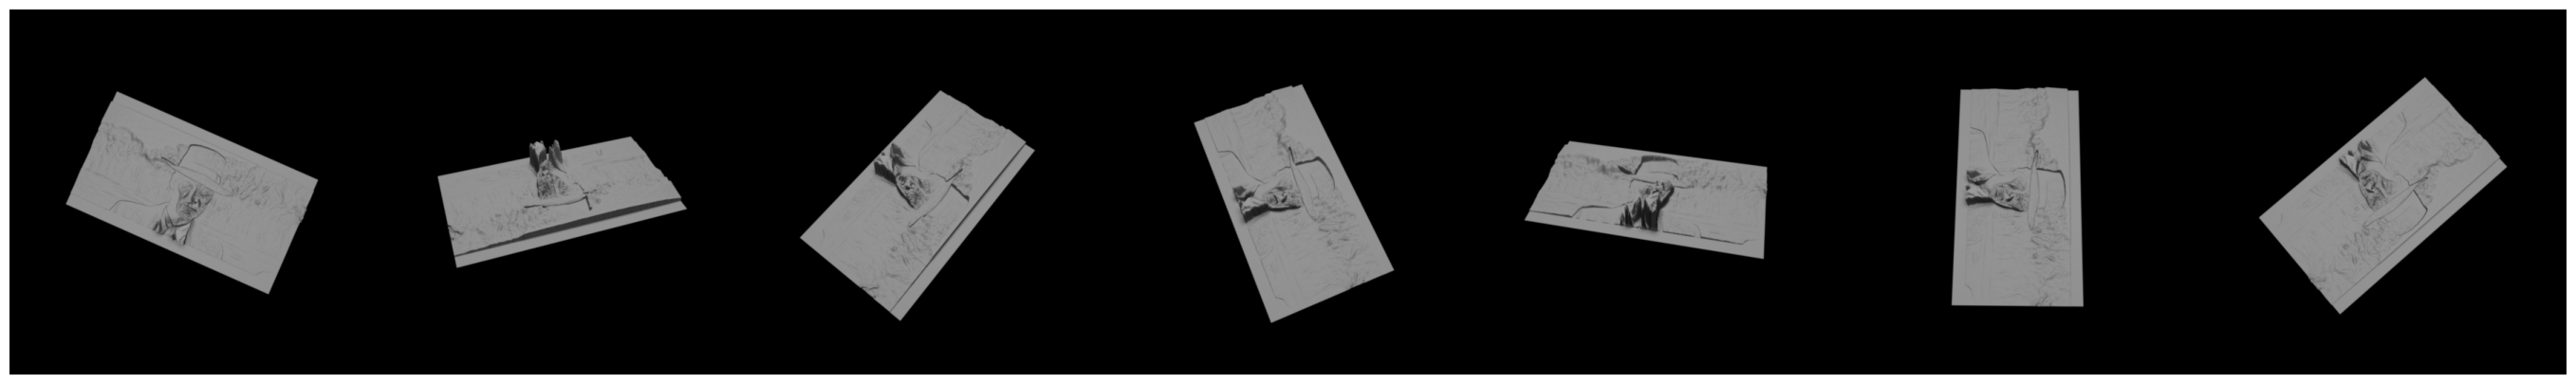

In [13]:
ref_img = mi.render(scene_target, spp=256)
plot_batch_output(ref_img)

In [14]:
mi.util.write_bitmap("output/gt/ref_img_oppenheimer.png", ref_img)

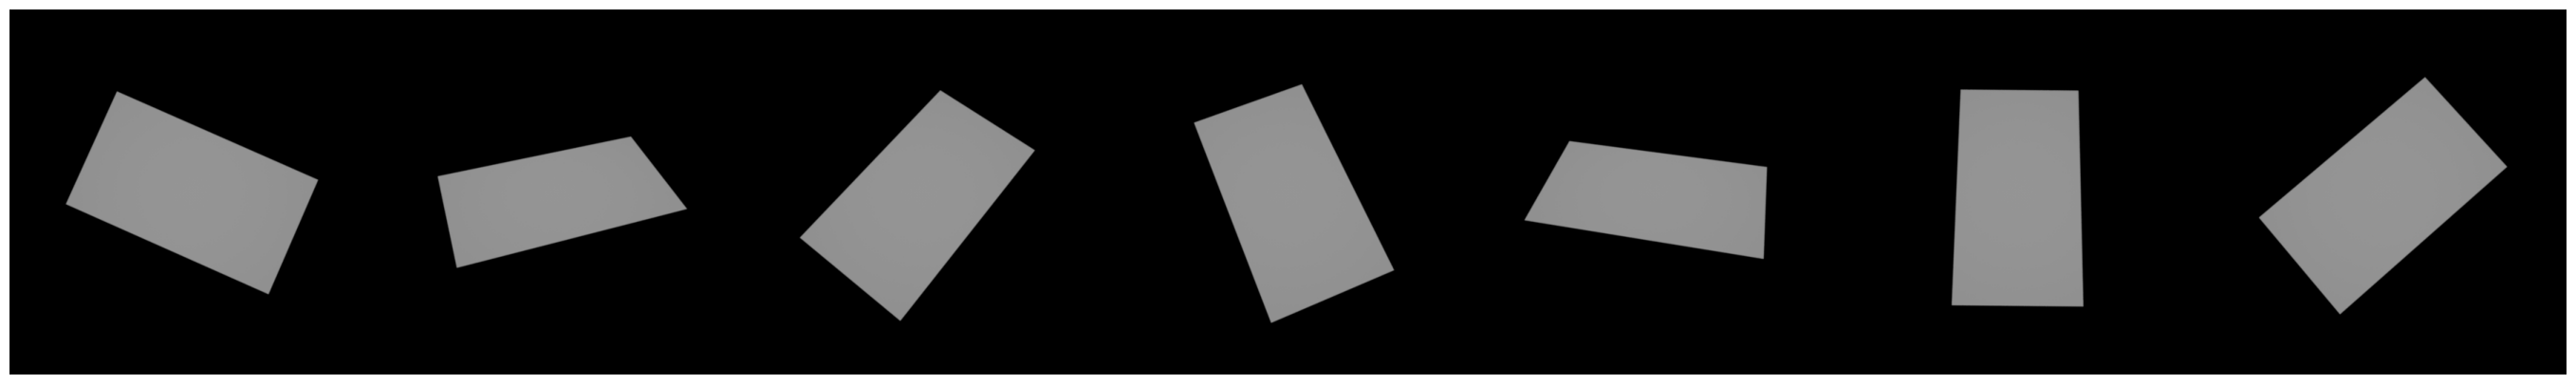

In [15]:
scene_source = mi.load_dict(scene_dict_opt)

init_img = mi.render(scene_source, spp=128)
plot_batch_output(init_img)

In [16]:
params = mi.traverse(scene_source)
res_x = params['heightfield.res_x']
res_y = params['heightfield.res_y']


In [17]:
def init_optimizer(lambda_, learning_rate = 0.1):
    ls = mi.ad.LargeSteps(params['heightfield.heightfield'], lambda_)
    opt = mi.ad.Adam(lr=learning_rate, uniform=True)
    opt['u'] = ls.to_differential(dr.clamp(params['heightfield.heightfield'], 0.0, 1.0), True)
    return ls, opt

In [19]:
iterations = 300
# upsampling_steps = dr.sqr(dr.linspace(mi.Float, 0, 1, 2+1, endpoint=False).numpy()[1:])
# upsampling_steps = (iterations * upsampling_steps).astype(int)
upsampling_steps = [50, 100, 200]

In [20]:
lambda_ = 30
ls, opt = init_optimizer(lambda_, 0.5)

In [21]:
for it in range(iterations):
    loss = mi.Float(0.0)
    
    if it in upsampling_steps:
        # params['heightfield.heightfield'] = dr.upsample(params['heightfield.heightfield'], scale_factor=(2, 2, 1))
        # params.update()
        # res_x = params['heightfield.res_x']
        # res_y = params['heightfield.res_y']
        lambda_ -= 5
        ls, opt = init_optimizer(lambda_, 0.6 * opt.lr['u'])
        # render_fd_gradient_img(scene_source, params, it)
        # render_reparam_gradient_img(scene_source, params, it)

    # Retrieve the vertex positions frimageom the latent variable
    t = dr.unravel(mi.Point3f, ls.from_differential(opt['u']))
    params['heightfield.heightfield'] = mi.TensorXf(t.z, (res_x,res_y,1))
    params.update()

    img = mi.render(scene_source, params, seed=it, spp=32)
    mi.util.write_bitmap(f"output/oppenheimer_optimization/iteration_{it}.png", img)
    
    # L1 Loss
    loss = dr.mean(dr.abs(img - ref_img))
    dr.backward(loss)
    opt.step()

    print(f"Iteration {1+it:03d}: Loss = {loss[0]:6f}", end='\r')

In [22]:
# Update the mesh after the last iteration's gradient step
t = dr.unravel(mi.Point3f, ls.from_differential(opt['u']))
params['heightfield.heightfield'] = mi.TensorXf(t.z, (res_x,res_y,1))
params.update()

[(Heightfield[
    to_world = [[1, 0, 0, 0],
                [0, 0.5625, 0, 0],
                [0, 0, 1, 0],
                [0, 0, 0, 1]],
    max height = 0.3,
    surface_area = [0],
    bsdf = SmoothDiffuse[
      reflectance = SRGBReflectanceSpectrum[
        value = [[0.5, 0.5, 0.5]]
      ]
    ]
  ],
  {'heightfield'}),
 (Scene[
    children = [
      Heightfield[
        to_world = [[1, 0, 0, 0],
                    [0, 0.5625, 0, 0],
                    [0, 0, 1, 0],
                    [0, 0, 0, 1]],
        max height = 0.3,
        surface_area = [0],
        bsdf = SmoothDiffuse[
          reflectance = SRGBReflectanceSpectrum[
            value = [[0.5, 0.5, 0.5]]
          ]
        ]
      ],
      DirectReparamIntegrator[max_depth = 6, rr_depth = 5],
      BatchSensor[0x7fa030019db0],
      Sphere[
        to_world = [[1, 0, 0, 0],
                    [0, 1, 0, 0],
                    [0, 0, 1, 5],
                    [0, 0, 0, 1]],
        center = [0, 0, 5],
      

In [17]:
def create_sensor_at_position(pos, resolution):
    moving_sensor = {
        'type': 'perspective',
        'fov': 45,
        'to_world': T.look_at(target=[0, 0, 0], origin=pos, up=[0, 0, 1]),
        'film': {
            'type': 'hdrfilm',
            'width': resolution[0], 'height': resolution[1],
            'filter': {'type': 'gaussian'},
            'sample_border': True
        }
    }
    return moving_sensor

In [18]:
# Extract final heightfield data
final_heightfield_res = (params['heightfield.res_x'], params['heightfield.res_y'])
final_heightfield = params['heightfield.heightfield']
final_img_res = 256

In [19]:
# Generate camera positions for final renders
sensor_count = 200
camera_points_circle = generate_points_circle(2, sensor_count, 5)

In [20]:
scene_dict_final = {
    'type': 'scene',
    'integrator': {
        'type': 'direct_reparam',
    },
    'sphere_2': {
        'type': 'sphere',
        'center': [0, 0, 5],
        'radius': 1,
       'emitter': {
            'type': 'area',
            'radiance': {
                'type': 'rgb',
                'value': 30.0,
            }
        }
    },
    'heightfield': {
        'type': 'heightfield',
        'resolution_x': final_heightfield_res[0],
        'resolution_y': final_heightfield_res[1],
        'max_height': 0.3,
        'bsdf': {
            'type': 'diffuse',
            'reflectance': {
                'type': 'rgb',
                'value': [0.5, 0.5, 0.5]
            }
        }
    }
}

In [27]:
# Render reconstructed shape from generated viewpoints
for i in range(len(camera_points_circle)):
    sensor = create_sensor_at_position(camera_points_circle[i], (2000, 2000))
    scene_dict_final['sensor'] = sensor
    scene_final = mi.load_dict(scene_dict_final)
    scene_final_params = mi.traverse(scene_final)
    scene_final_params['heightfield.heightfield'] = final_heightfield
    scene_final_params.update()

    final_img = mi.render(scene_final, spp=128)
    mi.util.write_bitmap(f"output/oppenheimer_final/circle_img{i}.png", final_img)


In [21]:
ref_params = mi.traverse(scene_target)
ref_heightfield = ref_params['heightfield.heightfield']
# Render reconstructed shape from generated viewpoints
for i in range(len(camera_points_circle)):
    sensor = create_sensor_at_position(camera_points_circle[i], (2000, 2000))
    scene_dict_final['sensor'] = sensor
    scene_final = mi.load_dict(scene_dict_final)
    scene_final_params = mi.traverse(scene_final)
    scene_final_params['heightfield.heightfield'] = ref_heightfield
    scene_final_params.update()

    final_img = mi.render(scene_final, spp=128)
    mi.util.write_bitmap(f"output/oppenheimer_reference/circle_img{i}.png", final_img)